In [17]:
from itertools import combinations
from math import floor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
df = pd.read_csv('bitcoin_features.csv', index_col='date', parse_dates=True)
df.head()

,close,volume,nbdi,days_elapsed,post_pandemic,pandemic_elapsed,calendar_year,calendar_month,calendar_day,calendar_weekday,...,close_lag6,close_lag7,nbdi_ma_30,nbdi_ma_90,nbdi_ma_180,nbdi_ma_365,volume_ma_30,volume_ma_90,volume_ma_180,volume_ma_365
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,435.40,3276.709621,114.1595,0.0,0.0,-1531.0,2016.0,1.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,431.91,3904.335318,114.1595,1.0,0.0,-1530.0,2016.0,1.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,433.85,5894.445723,114.1595,2.0,0.0,-1529.0,2016.0,1.0,3.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.34,5150.109476,114.1595,3.0,0.0,-1528.0,2016.0,1.0,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,430.87,5476.959959,114.2649,4.0,0.0,-1527.0,2016.0,1.0,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# create scaler
close_scaler = StandardScaler().fit(df.close.values.reshape(-1, 1))
volume_scaler = StandardScaler().fit(df.volume.values.reshape(-1, 1))
nbdi_scaler = StandardScaler().fit(df.nbdi.values.reshape(-1, 1))

In [4]:
# separate into pre and post pandemic segments
pre_pandemic = df[df.post_pandemic == 0]
pre_pandemic.loc[:, 'days_since_start'] = range(0, pre_pandemic.shape[0])
post_pandemic = df[df.post_pandemic == 1]
post_pandemic.loc[:, 'days_since_start'] = range(0, post_pandemic.shape[0])

/tmp/ipykernel_205921/2918195669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_pandemic.loc[:, 'days_since_start'] = range(0, pre_pandemic.shape[0])
/tmp/ipykernel_205921/2918195669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_pandemic.loc[:, 'days_since_start'] = range(0, post_pandemic.shape[0])


In [72]:
def regression_combinations(df: pd.DataFrame, target: str, temporal_features: list, features: list, split=0.8):
    def regression(df, target, temporal_feautres, features, split):
        use_features = [target, *temporal_features]
        if features:
            use_features.extend(features)
        
        feature_df = df.copy()[[*use_features]]
        feature_df.dropna(inplace=True)
    
        split_index = floor(feature_df.shape[0] * split)
        train = feature_df.iloc[:split_index]
        test = feature_df.iloc[split_index:]

        use_features.remove(target) # no leakage please
        
        y_train = train[target].values.reshape(-1, 1)
        X_train = train[[*use_features]].values
        
        y_test = test[target].values.reshape(-1, 1)
        X_test = test[[*use_features]].values

        model = LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return {
            'train_observations': train.shape[0],
            'test_observations': test.shape[0],
            'features': use_features,
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': root_mean_squared_error(y_test, y_pred)
        }

    n_features = len(features)
    feature_combinations = []
    for i in range(1, n_features + 1):
        combos = combinations(features, i)
        feature_combinations.extend(list(combos))
        
    results = []

    with tqdm(total=len(feature_combinations)) as pbar:
        result = regression(df, target, temporal_features, None, split) # first one with just temporal features
        results.append(result)
        pbar.update(1)
        for use_features in feature_combinations:
            result = regression(df, target, temporal_features, use_features, split)
            results.append(result)
            pbar.update(1)
        
    return results

In [73]:
temporal_features = [col for col in df.columns if 'calendar' in col or 'elapsed' in col or col == 'post_pandemic']
feature_list = [col for col in df.columns if col not in ['close', 'close_lag4', 'close_lag5', 'close_lag6', *temporal_feature_list]]
feature_list

['volume',
 'nbdi',
 'close_lag1',
 'close_lag2',
 'close_lag3',
 'close_lag7',
 'nbdi_ma_30',
 'nbdi_ma_90',
 'nbdi_ma_180',
 'nbdi_ma_365',
 'volume_ma_30',
 'volume_ma_90',
 'volume_ma_180',
 'volume_ma_365']

16384it [00:23, 695.50it/s]                                                                                             


volume: 655.0572161844574 / 557.7668047254003, 97.29041145905705
nbdi: 655.7649812302224 / 535.8260883066843, 119.9388929235381
close_lag1: 324.06317991035667 / 979.970601742367, -655.9074218320103
close_lag2: 403.5240519586785 / 900.5097296940453, -496.9856777353668
close_lag3: 436.9019083626477 / 867.1318732900759, -430.22996492742817
close_lag7: 486.65621716822614 / 817.3775644844976, -330.7213473162715
nbdi_ma_30: 659.7447542018592 / 644.2890274508643, 15.455726750994927
nbdi_ma_90: 660.8554982802673 / 643.1782833724562, 17.67721490781105
nbdi_ma_180: 645.4853125130554 / 658.5484691396681, -13.063156626612681
nbdi_ma_365: 690.686406623693 / 613.3473750290307, 77.33903159466229
volume_ma_30: 623.0480003863812 / 680.9857812663425, -57.93778087996134
volume_ma_90: 667.2704287191773 / 636.7633529335465, 30.507075785630832
volume_ma_180: 675.8591267414246 / 628.1746549112991, 47.68447183012552
volume_ma_365: 712.2008111462662 / 591.8329705064575, 120.36784063980872


,train_observations,test_observations,features,mse,rmse
0,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76804.840422,277.136862
1,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76903.893160,277.315512
2,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76979.989547,277.452680
3,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",76993.703855,277.477393
4,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",77018.079401,277.521313
5,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",77072.988002,277.620223
6,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",77086.590923,277.644721
7,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",77133.093878,277.728453
8,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",77134.233596,277.730505
9,933,234,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",77139.240936,277.739520


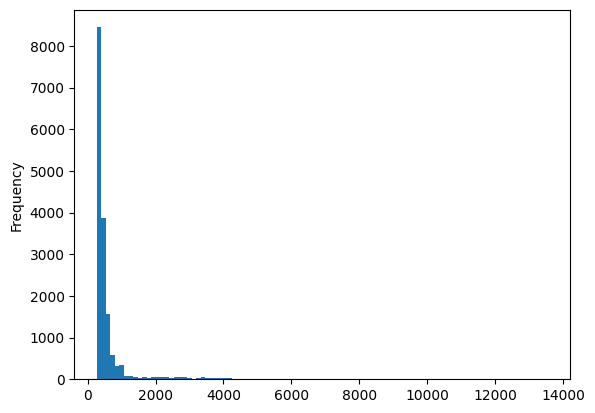

In [74]:
results = regression_combinations(pre_pandemic, 'close', temporal_feature_list, feature_list)
results_df = pd.DataFrame.from_dict(results)
results_df['features'] = results_df.features.apply(lambda x: ','.join(x))
results_df.sort_values('rmse', inplace=True, ignore_index=True)
results_df.to_csv('pre_pandemic_regression_results.csv', index=False)
results_df.rmse.plot.hist(bins=100)
for feature in feature_list:
    with_mean = results_df[results_df.features.str.contains(feature)].rmse.mean()
    without_mean = results_df[~results_df.features.str.contains(feature)].rmse.mean()
    print(f'{feature}: {with_mean} / {without_mean}, {with_mean - without_mean}')
results_df.head(10)

16384it [00:22, 732.05it/s]                                                                                             


,train_observations,test_observations,features,mse,rmse
0,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",443889.309620,666.250185
1,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",444099.922318,666.408225
2,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",444147.019057,666.443560
3,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",445607.447714,667.538349
4,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",445618.642332,667.546734
5,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",446011.895824,667.841221
6,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",446020.741614,667.847843
7,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",446155.211636,667.948510
8,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",446232.596226,668.006434
9,1113,279,"days_elapsed,post_pandemic,pandemic_elapsed,ca...",446261.336810,668.027946


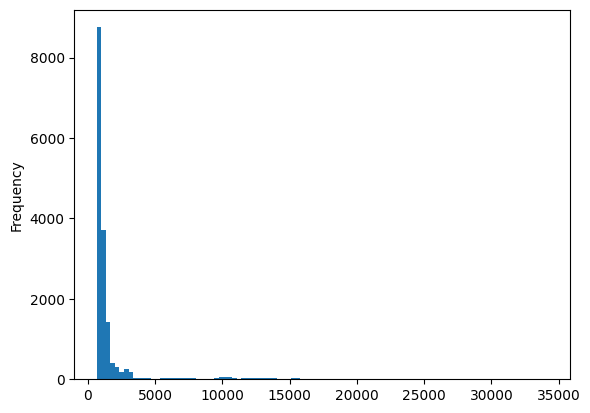

In [78]:
results = regression_combinations(post_pandemic, 'close', temporal_features, feature_list)
results_df = pd.DataFrame.from_dict(results)
results_df['features'] = results_df.features.apply(lambda x: ','.join(x))
results_df.sort_values('rmse', inplace=True, ignore_index=True)
results_df.to_csv('post_pandemic_multiple_regression_results.csv', index=False)
results_df.rmse.plot.hist(bins=100)
results_df.head(10)